# H3 Practice with 311 noise complaints from NYC

This notebook is practice for using the H3 package to build hexagons from points, cells and information taken from tutorial at this link: (Tutorial at this link: https://github.com/uber/h3-py-notebooks)

# UnifiedDataLayers 
*Author: Sina Kashuk*

### Summary: 
One of the applications of hexagons is to be able to combine different datasets with different geographic shapes and forms. In this tutorial we are going through an example of how to bring the US census data, NYC 311 Noise complaints, and Digital Elevation Model to the hexagon aperture and then how to visualize the data to gain insight.

### Data
* **POLYGON:** Census Tract Data [[Source]](https://www.census.gov/data.html)
* **POINT:** NYC 311 noise complaints [[Source]](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/7ahn-ypff)
* **RASTER:** NYC Digital Elevation Model [[Source]](https://data.cityofnewyork.us/City-Government/1-foot-Digital-Elevation-Model-DEM-Integer-Raster/7kuu-zah7/)

In [17]:
# functions also taken from tutorial at link above
import h3
import json
import copy
import base64
import urllib
import shapely
import geojson
from geojson import Feature, FeatureCollection
import tempfile
import pandas as pd
import geopandas as gpd
import branca.colormap as cm
from branca.colormap import linear
import folium
from folium import Map, Marker, GeoJson
from folium.plugins import MarkerCluster
#from area import area
from geopandas import GeoDataFrame
from shapely.geometry import mapping
from shapely.ops import cascaded_union
import matplotlib.pyplot as plt
%matplotlib inline

#Functions
def plot_scatter(df, metric_col, x='lng', y='lat', marker='.', alpha=1, figsize=(16,12), colormap='viridis'):    
    df.plot.scatter(x=x, y=y, c=metric_col, title=metric_col
                    , edgecolors='none', colormap=colormap, marker=marker, alpha=alpha, figsize=figsize);
    plt.xticks([], []); plt.yticks([], [])

def aperture_downsampling(df, hex_col, metric_col, coarse_aperture_size):
    df_coarse = df.copy()
    coarse_hex_col = 'hex{}'.format(coarse_aperture_size)
    df_coarse[coarse_hex_col] = df_coarse[hex_col].apply(lambda x: h3.h3_to_parent(x,coarse_aperture_size))
    dfc = df_coarse.groupby([coarse_hex_col])[[metric_col,]].mean().reset_index()
    dfc['lat'] = dfc[coarse_hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfc['lng'] = dfc[coarse_hex_col].apply(lambda x: h3.h3_to_geo(x)[1]) 
    return dfc

def kring_smoothing(df, hex_col, metric_col, k):
    dfk = df[[hex_col]] 
    dfk.index = dfk[hex_col]
    dfs =  (dfk[hex_col]
                 .apply(lambda x: pd.Series(list(h3.k_ring(x,k)))).stack()
                 .to_frame('hexk').reset_index(1, drop=True).reset_index()
                 .merge(df[[hex_col,metric_col]]).fillna(0)
                 .groupby(['hexk'])[[metric_col]].sum().divide((1 + 3 * k * (k + 1)))
                 .reset_index()
                 .rename(index=str, columns={"hexk": hex_col}))
    dfs['lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['lng'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1]) 
    return dfs

def weighted_kring_smoothing(df, hex_col, metric_col, coef):
    # normalize the coef
    a = []
    for k, coe in enumerate(coef):
        if k == 0:
            a.append(coe)
        else:
            a.append(k * 6 * coe)
    coef = [c / sum(a) for c in coef]
    
    # weighted smoothing 
    df_agg = df[[hex_col]]
    df_agg['hexk'] = df_agg[hex_col]
    df_agg.set_index(hex_col,inplace=True)
    temp2 = [df_agg['hexk'].reset_index()]
    temp2[-1]['k'] = 0
    K=len(coef)-1 
    for k in range(1,K+1):
        temp2.append((df_agg['hexk']
                     .apply(lambda x: pd.Series(list(h3.hex_ring(x,k)))).stack()
                     .to_frame('hexk').reset_index(1, drop=True).reset_index()
                ))
        temp2[-1]['k'] = k
    df_all = pd.concat(temp2).merge(df)
    df_all[metric_col] = df_all[metric_col]*df_all.k.apply(lambda x:coef[x])
    dfs = df_all.groupby('hexk')[[metric_col]].sum().reset_index().rename(index=str, columns={"hexk": hex_col})
    dfs['lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['lng'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
    return dfs

def visualize_hexagons(hexagons, color="black", folium_map=None):
    """
    hexagons is a list of hexcluster. Each hexcluster is a list of hexagons. 
    eg. [[hex1, hex2], [hex3, hex4]]
    """
    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        # flatten polygons into loops.
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    
    if folium_map is None:
        m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
    else:
        m = folium_map
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=.5,color=color)
        m.add_child(my_PolyLine)
    return m
    

def visualize_polygon(polyline, color):
    polyline.append(polyline[0])
    lat = [p[0] for p in polyline]
    lng = [p[1] for p in polyline]
    m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
    my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
    m.add_child(my_PolyLine)
    return m

### 1. Grabbing Data from NYC 311 API

The cell below grabs the json data from the NYC 311 API, but it can also grab the geojson by chaning the extension to .geojson

In [2]:
with urllib.request.urlopen("https://data.cityofnewyork.us/resource/erm2-nwe9.json") as url:
    data = json.loads(url.read().decode())

### 2. Cleaning the Data

The data needs to be cleaned by normalizing the json, dropping duplicated oclumns, changing the data type from str to float and removing any lat/longs that are outliers and most likely due to an error

In [3]:
df_311 = pd.json_normalize(data)
df_311 = df_311.dropna(axis=1, how='all')
df_311 = df_311.drop(['location.latitude','location.longitude'], axis=1)
#df_311

In [4]:
df_311['latitude'] = df_311['latitude'].astype('float')
df_311['longitude'] = df_311['longitude'].astype('float')
#df_311

In [5]:
outlier = df_311.loc[df_311['longitude']<= -77]
#outlier

In [6]:
df_311.drop(df_311[df_311['longitude']<= -77].index, inplace = True)
#df_311

### 3. Visualizing the Data

Now the data points can be visualized before the hexbins are created

Text(0.5, 1.0, 'Sample points: 311 noise complaints')

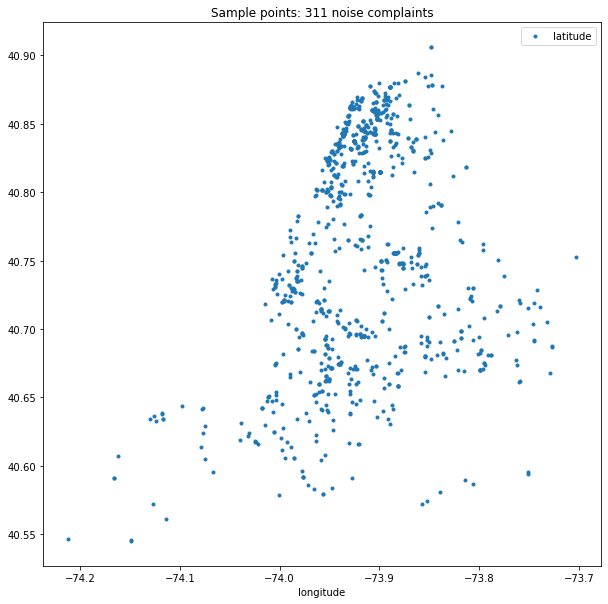

In [7]:
df_311.plot(x='longitude', y='latitude', style='.', alpha=1, figsize=(10,10))
plt.title('Sample points: 311 noise complaints')

### 4. Transforming the 311 Data to HEX

The cell bellow was taken from the tutorial above, but changed to use the data that is grabbed from the 311 api rather than a csv. The hexbins are then visualized using a scatter plot.

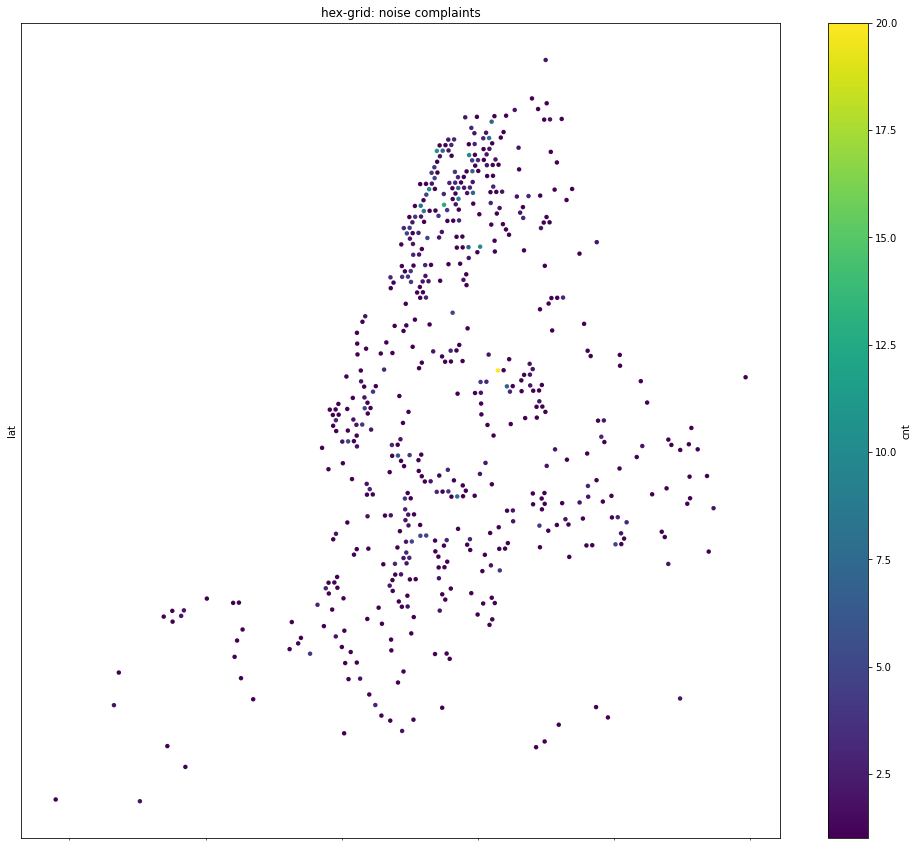

In [8]:
APERTURE_SIZE = 9
hex_col = 'hex'+str(APERTURE_SIZE)


# find hexs containing the points
df_311[hex_col] = df_311.apply(lambda x: h3.geo_to_h3(x.latitude,x.longitude,APERTURE_SIZE),1)

# aggregate the points
df_311g = df_311.groupby(hex_col).size().to_frame('cnt').reset_index()

#find center of hex for visualization
df_311g['lat'] = df_311g[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
df_311g['lng'] = df_311g[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

# pltot the hexs
plot_scatter(df_311g, metric_col='cnt', marker='o',figsize=(17,15))
plt.title('hex-grid: noise complaints');

In [ ]:
#df_311g This just allows you to look at the resulting dataframe

### 5. Spatial Smoothing 

The cell bellow was also taken from the tutorial above and reformatted to accpet the current data. This runs a kring smoothing on the 311 data and shows "hotspots"

sum sanity check: 1.0


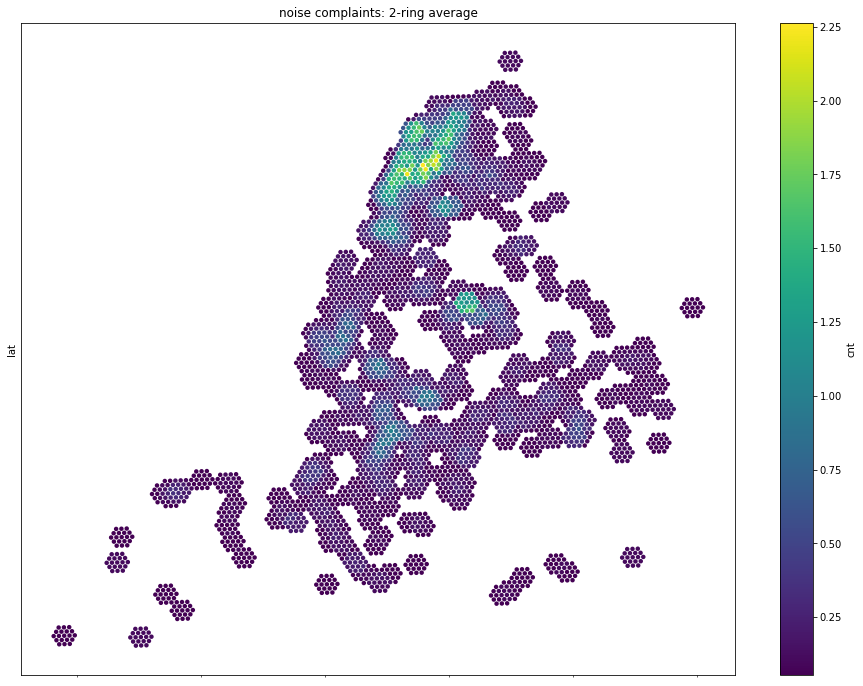

In [9]:
#kring_smoothing
k = 2
df311s= kring_smoothing(df_311g, hex_col, metric_col='cnt', k=k)
print('sum sanity check:', df311s['cnt'].sum() / df_311g['cnt'].sum())
plot_scatter(df311s, metric_col='cnt', marker='o')
plt.title('noise complaints: 2-ring average');

### 6. Adding Geometry to Dataframe

The cell bellow was taken from another tutorial from the link above. It creates a geometry field, which will assist in creation of a geojson to overlay on a folium map.

In [10]:
df311s["geometry"] =  df311s.hex9.apply(lambda x: 
                                                           {    "type" : "Polygon",
                                                                 "coordinates": 
                                                                [h3.h3_to_geo_boundary(x,geo_json=True)]
                                                            }
                                                        )
#df311s uncomment to check the geometry column

### 7. Visualizing hexbins with Folium

In [11]:
m = visualize_hexagons(df311s['hex9'])
display(m)

### 8. Visualization with Choropleth map and Folium 

These two functions were taken from the same tutorial as above, but again modified to accept the current dataframe. The first function takes the h3 hexagons and turns them into a geojson. The second function takes the geojson and creates a colormap to be overlayed onto a folium basemap.

In [12]:
def hexagons_dataframe_to_geojson(df_hex, file_output = None):
    
    '''Produce the GeoJSON for a dataframe that has a geometry column along with the columns hex9 and value '''
    
    list_features = []
    
    for i,row in df_hex.iterrows():
        feature = Feature(geometry = row["geometry"] , id=row["hex9"], properties = {"value" : row["cnt"]})
        list_features.append(feature)
        
    feat_collection = FeatureCollection(list_features)
    
    geojson_result = json.dumps(feat_collection)
    
    #optionally write to file
    if file_output is not None:
        with open(file_output,"w") as f:
            json.dump(feat_collection,f)
    
    return geojson_result

In [33]:
def choropleth_map(df, border_color = 'black', fill_opacity = 0.5, initial_map = None, with_legend = False,
                   kind = "linear"):
    #colormap
    min_value = df["cnt"].min()
    max_value = df["cnt"].max()
    m = round ((min_value + max_value ) / 2 , 0)
    
    #take resolution from the first row
    res = h3.h3_get_resolution(df['hex9'].iloc[0])
    
    if initial_map is None:
        initial_map = Map(location= [40.7128, -74.0060], zoom_start=11, tiles="cartodbpositron", 
                attr= '© <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors © <a href="http://cartodb.com/attributions#basemaps">CartoDB</a>' 
            )
        

    #the colormap 
    #color names accepted https://github.com/python-visualization/branca/blob/master/branca/_cnames.json
    if kind == "linear":
        custom_cm = cm.LinearColormap(['darkblue','darkturquoise','yellow'], vmin=min_value, vmax=max_value)
    elif kind == "outlier":
        #for outliers, values would be -11,0,1
        custom_cm = cm.LinearColormap(['blue','white','red'], vmin=min_value, vmax=max_value)
    elif kind == "filled_nulls":
        custom_cm = cm.LinearColormap(['sienna','green','yellow','red'], 
                                      index=[0,min_value,m,max_value],vmin=min_value,vmax=max_value)
   

    #create geojson data from dataframe
    geojson_data = hexagons_dataframe_to_geojson(df_hex = df)
    
    #plot on map
    name_layer = "Choropleth " + str(res)
    if kind != "linear":
        name_layer = name_layer + kind
        
    GeoJson(
        geojson_data,
        style_function=lambda feature: {
            'fillColor': custom_cm(feature['properties']['value']),
            'color': border_color,
            'weight': 1,
            'fillOpacity': fill_opacity 
        }, 
        name = name_layer
    ).add_to(initial_map)

    #add legend (not recommended if multiple layers)
    if with_legend == True:
        custom_cm.add_to(initial_map)
    
    
    
    return initial_map

    

In [34]:
m_hex = choropleth_map(df= df311s, with_legend = True)

m_hex.save('source/3_choropleth_counts_by_hexid9.html')
m_hex
